In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
def get_unique_data(target_dataframe, end_target_columns):
    # Get the number of columns
    n_cols = target_dataframe.shape[1]

    # Get the last 7 columns
    df_last_7_columns = target_dataframe.iloc[:, -end_target_columns:]

    # Create a dictionary to store the unique values with their column name
    unique_values = {col: df_last_7_columns[col].unique() for col in df_last_7_columns.columns}

    # Create a new Series from the dictionary
    unique_series = pd.Series(unique_values)
    return unique_series

# 1: Dataframe analysis

In [3]:
# Load the data from the CSV file
dev_df = pd.read_csv('development.csv')
dev_df.drop('Id', axis=1, inplace=True)

#TODO REMOVE ME
dev_df = dev_df.sample(frac=0.02, random_state=42)
df_unique_data = get_unique_data(dev_df, 7)
df_unique_data

action                                   [decrease, change language, increase, activate...
object                                                 [volume, heat, none, music, lights]
Self-reported fluency level                                      [native, advanced, basic]
First Language spoken                           [English (United States), French (Canada)]
Current language used for work/school    [English (United States), English (Australia),...
gender                                                                      [male, female]
ageRange                                                               [41-65, 22-40, 65+]
dtype: object

In [4]:
eval_df = pd.read_csv('evaluation.csv')

df_unique_data = get_unique_data(eval_df, 4)
df_unique_data

First Language spoken                    [English (United States)]
Current language used for work/school    [English (United States)]
gender                                              [male, female]
ageRange                                            [22-40, 41-65]
dtype: object

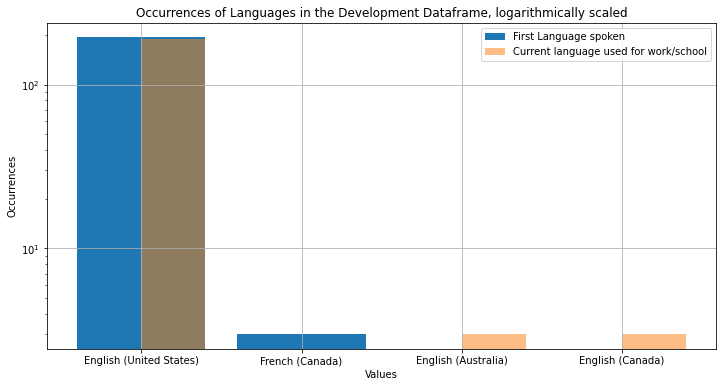

In [5]:
col1_counts = dev_df['First Language spoken'].value_counts()

# Count the occurrences of each value in the second column
col2_counts = dev_df['Current language used for work/school'].value_counts()

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(col1_counts.index, col1_counts.values, label='First Language spoken')
ax.bar(col2_counts.index, col2_counts.values, label='Current language used for work/school', width=0.4, align='edge',
       alpha=0.5)

# Add a legend and display the chart
ax.legend()
ax.set_yscale('log')  # this line add the y-axis scaling to logarithmic
plt.xlabel("Values")
plt.grid()
plt.ylabel("Occurrences")
plt.title("Occurrences of Languages in the Development Dataframe, logarithmically scaled")
plt.show()

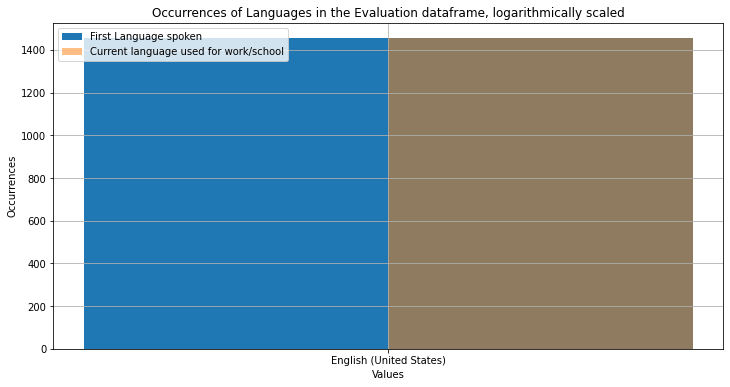

In [6]:
col1_counts = eval_df['First Language spoken'].value_counts()

# Count the occurrences of each value in the second column
col2_counts = eval_df['Current language used for work/school'].value_counts()

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(col1_counts.index, col1_counts.values, label='First Language spoken')
ax.bar(col2_counts.index, col2_counts.values, label='Current language used for work/school', width=0.4, align='edge',
       alpha=0.5)

# Add a legend and display the chart
ax.legend()
plt.xlabel("Values")
plt.grid()
plt.ylabel("Occurrences")
plt.title("Occurrences of Languages in the Evaluation dataframe, logarithmically scaled")
plt.show()

In [7]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 8353 to 251
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   path                                   197 non-null    object
 1   speakerId                              197 non-null    object
 2   action                                 197 non-null    object
 3   object                                 197 non-null    object
 4   Self-reported fluency level            197 non-null    object
 5   First Language spoken                  197 non-null    object
 6   Current language used for work/school  197 non-null    object
 7   gender                                 197 non-null    object
 8   ageRange                               197 non-null    object
dtypes: object(9)
memory usage: 15.4+ KB


# 2: Dataframe cleaning

In [8]:
dev_df.head()

,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
8353,dsl_data/audio/speakers/ZebMRl5Z7dhrPKRD/d4441...,ZebMRl5Z7dhrPKRD,decrease,volume,native,English (United States),English (United States),male,41-65
9843,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/78636...,Pz327QrLaGuxW8Do,decrease,heat,native,English (United States),English (United States),female,22-40
1851,dsl_data/audio/speakers/BvyakyrDmQfWEABb/447cf...,BvyakyrDmQfWEABb,decrease,volume,native,English (United States),English (United States),male,22-40
7209,dsl_data/audio/speakers/xPZw23VxroC3N34k/9d35a...,xPZw23VxroC3N34k,change language,none,native,English (United States),English (United States),female,22-40
3742,dsl_data/audio/speakers/kNnmb7MdArswxLYw/42458...,kNnmb7MdArswxLYw,increase,volume,native,English (United States),English (United States),female,41-65


In [9]:
dev_df.drop(dev_df[dev_df['First Language spoken'] != 'English (United States)'].index, inplace=True)
dev_df.drop(dev_df[dev_df['Current language used for work/school'] != 'English (United States)'].index, inplace=True)
df_unique_data = get_unique_data(dev_df, 7)
df_unique_data

action                                   [decrease, change language, increase, activate...
object                                                 [volume, heat, none, music, lights]
Self-reported fluency level                                      [native, advanced, basic]
First Language spoken                                            [English (United States)]
Current language used for work/school                            [English (United States)]
gender                                                                      [male, female]
ageRange                                                               [41-65, 22-40, 65+]
dtype: object

# Extracting features

In [10]:
def create_sentence(row):
    if row["object"] == "none":
        return row["action"]
    else:
        return row["action"] + row["object"]

In [11]:
# apply the function to the dataframe
dev_df["sentence"] = dev_df.apply(create_sentence, axis=1)
dev_df.drop('action', axis=1, inplace=True)
dev_df.drop('object', axis=1, inplace=True)
dev_df.drop('First Language spoken', axis=1, inplace=True)
dev_df.drop('Current language used for work/school', axis=1, inplace=True)
dev_df.head()

,path,speakerId,Self-reported fluency level,gender,ageRange,sentence
8353,dsl_data/audio/speakers/ZebMRl5Z7dhrPKRD/d4441...,ZebMRl5Z7dhrPKRD,native,male,41-65,decreasevolume
9843,dsl_data/audio/speakers/Pz327QrLaGuxW8Do/78636...,Pz327QrLaGuxW8Do,native,female,22-40,decreaseheat
1851,dsl_data/audio/speakers/BvyakyrDmQfWEABb/447cf...,BvyakyrDmQfWEABb,native,male,22-40,decreasevolume
7209,dsl_data/audio/speakers/xPZw23VxroC3N34k/9d35a...,xPZw23VxroC3N34k,native,female,22-40,change language
3742,dsl_data/audio/speakers/kNnmb7MdArswxLYw/42458...,kNnmb7MdArswxLYw,native,female,41-65,increasevolume


In [12]:
def load_and_clean_audio(filepath):
    # Load the audio file
    y, sr = librosa.load(filepath)

    # Perform any necessary cleaning steps
    # for example removing silence at the beginning and end of the audio
    yt, _ = librosa.effects.trim(y)

    # Return the cleaned audio
    return yt


def extract_features(filepath):
    y = load_and_clean_audio(filepath)
    # Extract features from the audio
    mfcc = librosa.feature.mfcc(y=y, sr=22050, n_mfcc=40)
    return np.mean(mfcc, axis=1)

def extract_feature(file_name, mfcc, chroma, mel):
        X = load_and_clean_audio(file_name)
        sample_rate=X.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        return result

In [13]:
# Extract features for each audio file and store them in a new column
dev_df['path'].apply(extract_features)
dev_df['features'] =
dev_df = dev_df.drop("path", axis=1)

SyntaxError: invalid syntax (Temp/ipykernel_5784/560404159.py, line 3)

In [ ]:
dev_df.head()

# Training the ML

In [ ]:
# separate the target variable
y = dev_df["sentence"]
X = dev_df.drop("sentence", axis=1)
X.head()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# define the categorical columns
categorical_cols = ["speakerId",]

var = X[categorical_cols].shape()
l = pd.get_dummies(X[categorical_cols]).shape()
print(var)
print(l)
X.head()

In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# evaluate the model on the testing set
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))